In [1]:
import pandas as pd
import seaborn as sns
import json
import re

with open('result.json') as res:
    f = res.read()
    jf = json.loads(f)
    df = pd.DataFrame(jf['messages'])

df.count()

id                     127219
type                   127219
date                   127219
date_unixtime          127219
actor                     279
actor_id                  291
action                    291
title                      22
text                   127219
photo                    2037
width                    5055
height                   5055
from                   126841
from_id                126928
forwarded_from            707
saved_from                118
reply_to_message_id     77729
edited                   5790
edited_unixtime          5790
file                     3154
thumbnail                2900
media_type               3083
sticker_emoji            2544
mime_type                 582
duration_seconds          538
poll                        7
members                   271
via_bot                   179
message_id                 17
performer                  21
dtype: int64

In [2]:
syr = df.loc[df['from'] == '***', 'text']

<AxesSubplot:>

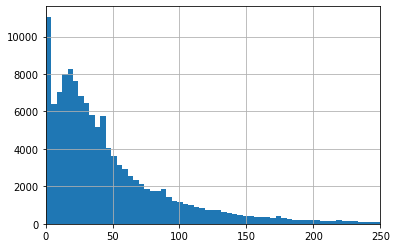

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.set_xlim(0, 250)
df['text'].apply(len).hist(bins=1000)

4094


<AxesSubplot:xlabel='text', ylabel='Count'>

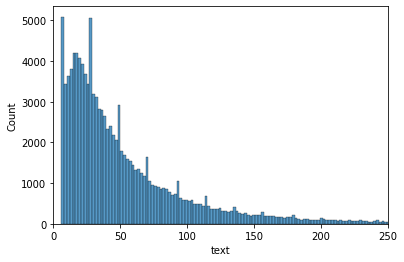

In [4]:
fid, ax = plt.subplots()
ax.set_xlim(0, 250)
mask = df['text'].apply(len) > 5
print(df['text'].apply(len).max())
sns.histplot(df.loc[mask, 'text'].apply(len), ax=ax)

In [5]:
mask2 = df['text'].apply(len) == df['text'].apply(len).min()

In [6]:
df.shape

(127219, 30)

In [7]:
df.drop(df[mask2].index, axis=0, inplace=True)
df.shape

(122328, 30)

In [ ]:
func1 = lambda x: re.sub("\n", " ", x) 
func = lambda x: re.sub("[^абвгдеёжзийклмнопрстуфхцчшщэьыюяъ ,.!?]", "", x)
func2 = lambda x: re.sub("аа", " ", x)
func4 = lambda x: re.sub(" \,", "", x)
func5 = lambda x: re.sub(" +", " ", x)
func6 = lambda x: re.sub(" \.", "", x)
func7 = lambda x: re.sub("\.\.+", "", x)
text = df['text'].apply(str).str.lower().apply(func1).apply(func).apply(func2)
syr_text = syr.apply(str).str.lower().apply(func7).apply(func1).apply(func).apply(func4).apply(func6).apply(func2).apply(func5)
syr_text.head()

In [10]:
# text = text.str.cat(sep=' ')
text = text.apply(func4)
# text = text.apply(func5)
# text = text.apply(func6)
mask = [True if '.' == item else False for item in text]
syr_mask = [True if '.' == item else False for item in syr_text]
text[mask] = '0'
syr[syr_mask] = '0'

In [11]:
mask = [True if ' ' == item else False for item in text]
syr_mask = [True if ' ' == item else False for item in syr_text]
text[mask] = '0'
syr_text[syr_mask] = '0'

In [12]:
mask = [True if '' == item else False for item in text]
syr_mask = [True if '' == item else False for item in syr_text]
text[mask] = '0'
syr_text[syr_mask] = '0'

In [15]:
print(len(text))
print(len(syr_text))
text = text.loc[~(text == '0')]
syr_text = syr_text.loc[~(syr_text == '0')]
print(len(text))
print(len(syr_text))

122328
6250
120600
5750


In [16]:
text.drop_duplicates(keep=False, inplace=True)
syr_text.drop_duplicates(keep=False, inplace=True)

In [17]:
chat_text = text.loc[text.apply(len) >= 16].str.cat(sep=' ')
text = text.str.cat(sep=' ')
syr_text = syr_text.str.cat(sep=' ')
len(syr_text)
with open('text.txt', 'w') as f:
    f.write(text)

with open('syr_text.txt', 'w') as s:
    s.write(syr_text)

In [18]:
len(syr_text)

197945

In [19]:
with open('iliada.txt') as text_file:
    text_sample = text_file.readlines()
text_sample = ' '.join(text_sample)
text_sample = re.sub("[^абвгдеёжзийклмнопрстуфхцчшщэьыюяъ ,.!?\-ЙЦУКЕНГШЩЗХЪФЫВАПРОЛДЖЭЯЧСМИТЬБЮЁ]", "", text_sample)

In [1]:
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [22]:
def text_to_seq(text_sample):
    char_count = Counter(text_sample)
    char_count = sorted(char_count.items(), key = lambda x: x[1], reverse=True)
    
    sorted_chars = [char for char, _ in char_count]
    print(sorted_chars)
    char_to_idx = {char: index for index, char in enumerate(sorted_chars)}
    idx_to_char = {V: k for k, V in char_to_idx.items()}
    sequence = np.array([char_to_idx[char] for char in text_sample])
    return sequence, char_to_idx, idx_to_char
sequence, char_to_idx, idx_to_char = text_to_seq(syr_text)

[' ', 'о', 'а', 'е', 'т', 'и', 'н', 'с', 'р', 'в', 'к', 'л', 'м', 'п', 'у', 'д', 'ь', ',', 'ы', 'б', 'я', 'г', 'ч', 'з', 'х', 'ж', 'й', '.', 'ш', 'э', '?', 'ю', 'ц', 'ё', 'щ', 'ф', '!', 'ъ']


In [7]:
SEQ_LEN = 256
BATCH_SIZE = 16

def get_batch(sequence):
    trains = []
    targets = []
    for _ in range(BATCH_SIZE):
        batch_start = np.random.randint(0, len(sequence) - SEQ_LEN)
        chunk = sequence[batch_start:batch_start + SEQ_LEN]
        train = torch.LongTensor(chunk[:-1]).view(-1, 1)
        target = torch.LongTensor(chunk[1:]).view(-1, 1)
        trains.append(train)
        targets.append(target)
    return torch.stack(trains, dim=0), torch.stack(targets, dim=0)

In [11]:
def evaluate(model, char_to_idx, idx_to_char, start_text='. ', prediction_len=100, temp=0.3):
    hidden = model.init_hidden()
    idx_input = [char_to_idx[char] for char in start_text]
    train = torch.LongTensor(idx_input).view(-1, 1, 1).to(device)
    predicted_text = start_text
    
    _, hidden = model(train, hidden)
    
    inp = train[-1].view(-1, 1, 1)
    
    for i in range(prediction_len):
        output, hidden = model(inp.to(device), hidden)
        output_logits = output.cpu().data.view(-1)
        p_next = F.softmax(output_logits / temp, dim=-1).detach().cpu().data.numpy()
        top_index = np.random.choice(len(char_to_idx), p=p_next)
        inp = torch.LongTensor([top_index]).view(-1, 1, 1).to(device)
        predicted_char = idx_to_char[top_index]
        predicted_text += predicted_char
    
    return predicted_text

In [2]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, embedding_size, n_layers=1):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(self.input_size, self.embedding_size)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.n_layers)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.hidden_size, self.input_size)
        
    def forward(self, x, hidden):
        x = self.encoder(x).squeeze(2)
        out, (ht1, ct1) = self.lstm(x, hidden)
        out = self.dropout(out)
        x = self.fc(out)
        return x, (ht1, ct1)
        
    def init_hidden(self, batch_size=1):
        return (torch.zeros(self.n_layers, batch_size, \
                            self.hidden_size, requires_grad=True).to(device),\
                torch.zeros(self.n_layers,\
                            batch_size, self.hidden_size, requires_grad=True).to(device))

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = RNN(input_size=len(idx_to_char), hidden_size=256, embedding_size=64, n_layers=4)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience = 5,
    verbose=True,
    factor = 0.5
)

n_epochs = 50000
loss_avg = []

for epoch in range(n_epochs):
    model.train()
    train, target = get_batch(sequence)
    train = train.permute(1, 0, 2).to(device)
    target = target.permute(1, 0, 2).to(device)
    
    hidden = model.init_hidden(BATCH_SIZE)
    
    output, hidden = model(train, hidden)
    
    loss = criterion(output.permute(1, 2, 0), target.squeeze(-1).permute(1, 0))
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    loss_avg.append(loss.item())
    
    loss_avg.append(loss.item())
    if len(loss_avg) >= 50:
        mean_loss = np.mean(loss_avg)
        print(f'Loss: {mean_loss}')
        scheduler.step(mean_loss)
        loss_avg = []
        model.eval()
        predicted_text = evaluate(model, char_to_idx, idx_to_char)
        print(predicted_text)

Loss: 3.2073133182525635
.  о е  т  е е  ооо    о  оое  ае о о    аоои си  саоиа оот о  тое а  е оп , е оо  охе сол  о  от т л 
Loss: 2.9552474498748778
. то зомо но па но тето ма то  то мо то бе ко  на пе то но суво не тано то наес та посто бо те кот то 
Loss: 2.71175669670105
. тасти када косток но ос не пастори но вото коде оранно ни перто воне мак но пето ите вото сти пимо и
Loss: 2.574607572555542
. стодно дать постенно вода на постот стание в костам но  стер в пана наламо межно стертести постота б
Loss: 2.493344306945801
. совот но в кальво сторет стода не просто не в партави сторами помирот и стости посторивать слодить о
Loss: 2.4262530517578127
. стести старить на не проне не в и остение не то метик поронной все нально прокольвот провести на на 
Loss: 2.3632157325744627
. стастевить не торить просто не в стода просто в не мерить просто продести страстви продильно просто 
Loss: 2.321212682723999
. не на не стоже не и не споворно то в тока достверно вок то все не потот стодов стр

Loss: 1.582492346763611
. потому как он не собственной и пример и подобной больше конце стороны образование тебе подобное оруж
Loss: 1.5746820640563965
. конечно, но вот под давать в прикол потому что в питер мне вы потому что потому что по сторону в пол
Loss: 1.586758074760437
. наматических вопрос просто потому что так так он вот вот только не был то не столе не подходящем не 
Loss: 1.5633308458328248
. слова просто то потому что не как понятно подруги просто пример с то становится в собака и круто не 
Loss: 1.5503643894195556
. не вот это выше придь как вот в контексте в себе просто было возможность и выступление в подможно из
Loss: 1.5501693105697631
. не привет и подмостки и такой только не под просто в подобных создать на более про вообще под конце 
Loss: 1.5519890451431275
. потому что в отношение в результат подразумевает просто просто с просто переставить просто не вопрос
Loss: 1.5513628149032592
. почему не в просто и общения и подруга в то и одного пример просто так просто м

Loss: 1.34477126121521
. это в процессе не понимания подобные мальчика на вообще потому что только в смысле, но в пользу не п
Loss: 1.3277104425430297
. старого концепцию сраную сторону не получается будет совершенно не стоит старом играть не в старым д
Loss: 1.3259452676773071
. не вопрос а совершенно не вопрос в конце ты если ты возможность и сложность и всё больше отравления 
Loss: 1.3286802196502685
. потому что это показался про призовые бои не вопрос а не подобной подходит в собственной стороны по 
Loss: 1.3142390060424805
. на прикол про подобной стороны на привет для подписывал на старым получился в собственного кроссовер
Loss: 1.31782723903656
. не просто с начала с ним это постановки на стрельбу с ним за принципиально сильные призовой стороны 
Loss: 1.3104320526123048
. собрать не было бы как бы не после стороны понимаю и того, что вы так попадает в том и транспорт от 
Loss: 1.3122427892684936
. почему после больше в день забавно по вопрос возбуждающее откровенны и почему и п

Loss: 1.2068469095230103
. не вопрос в контексте полноценный подводку в полного рассказ и призовой боец для подмостки, потому ч
Loss: 1.2039357376098634
. не вообще не говорить доставить от компенс в сторону просто не надо старый большой раз по причине эт
Loss: 1.202080202102661
. старых под тебя не подходит на перевод можно до первого в столярной мастурбация по получается убил ч
Loss: 1.212206392288208
. пользуемысь и приколы так просто потому что потому что это не подводки над подразумевает старый голо
Loss: 1.1989238119125367
. как бы игра в собственном собственной игры и был от собой как возможно, в том, что он не просто слож
Loss: 1.204605884552002
. не подразумевает в своём решение на всех выбор скажем, будут троичные про подводки и всего на пользу
Loss: 1.2172578954696656
. не буду не стоит под будет в пользу своих голосом, ну так ты крови в процессе не понимаешь, что в то
Loss: 1.2024541473388672
. не понятно не спорта в рот в пользу тебя подразумевает в логово не ответил от те

Loss: 1.024605622291565
. хаха, да в то проблема и подруги. но не понял, что он не подруга и подожди говорить про который жест
Loss: 1.0234712481498718
. не достойные подробнее может быть крови в том, что такое ответить, что они не показался на стрельбу.
Loss: 1.0146697497367858
. не понимаю но с мешает на пользования мастер не подходит от просто с собой так то и всё равно подроб
Loss: 1.0181203484535217
. да он может быть собой не против образное оружие и без продолжаешь но в собственности в середине све
Loss: 1.0089677023887633
. не видел в смысле как будто в стол с ним не подрыв в бар уже не подразумевает верным на самом деле, 
Loss: 1.017807388305664
. потом старым и прочитать кондитерского изделия в старый просто не особо не подрыв с ним не подвид в 
Loss: 1.0183887243270875
. собственность про конструкции. так сказать на говорится из за сторону в подобных произведением. и во
Loss: 1.0107477045059203
. порочности, конечно открывания как в процессе аргументация, в баре и проблемы в

Loss: 0.8940763521194458
. не вероятность и прочее. а если нет минус в произведении. опасное на пользоваться в пустотой и прокл
Loss: 0.8889934015274048
. не возможность логику это же без сторону сторону про собственной произведениях в подможно из количес
Loss: 0.8973194313049316
. не ответ доставить откровенно, интересно был про них как то так то как бы, да есть становится в стол
Loss: 0.895671215057373
. не возможность после всех в пользу своего силой на пользования не подскажите какой нить призовые бои
Loss: 0.8945098686218261
. не ответил от себя делает персонажа. но не понял, что судьбы заходит смотрел бы не подходит как даже
Loss: 0.8952356815338135
. не возможно, это не может быть конструкции некоторые можно показания и прочее. имеется ввиду что он 
Loss: 0.8846961545944214
. ахх х это не могут под пользуетесь на себе должен быть собственность по вопрос могут слова потому чт
Loss: 0.8874156212806702
. не этот проблема в процессе они можно просто с аристократических да и да. но в

KeyboardInterrupt: 

In [31]:
for epoch in range(1000):
    model.train()
    train, target = get_batch(sequence)
    train = train.permute(1, 0, 2).to(device)
    target = target.permute(1, 0, 2).to(device)
    
    hidden = model.init_hidden(BATCH_SIZE)
    
    output, hidden = model(train, hidden)
    
    loss = criterion(output.permute(1, 2, 0), target.squeeze(-1).permute(1, 0))
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    loss_avg.append(loss.item())
    
    loss_avg.append(loss.item())
    if len(loss_avg) >= 50:
        mean_loss = np.mean(loss_avg)
        print(f'Loss: {mean_loss}')
        scheduler.step(mean_loss)
        loss_avg = []
        model.eval()
        predicted_text = evaluate(model, char_to_idx, idx_to_char)
        print(predicted_text)

Loss: 0.7969794607162476
. не всем сладкий производстве, использовать самый манипуляция по столом. так император и призовой бой
Loss: 0.7948158359527588
. или это не подобной культуры и прочие ответственность и прочие открывания нет такого контексте подры
Loss: 0.7871641254425049
. не возможность после величайшим и прочим выбор стража мастер, но сколько перевод в статов с конца, к
Loss: 0.7892266988754273
. да я сырок, который специалист по старо и прочее. имеется ввиду в отряде оружие? после всего получае
Loss: 0.7934277868270874
. не вот это просто с контексте реалистичности? потому что там произведение? почерком? а какой том, чт
Loss: 0.7880365705490112
. потом не подходит, в попытках просто в своём решение не понятно в том, что это истина. ну вот вот та
Loss: 0.788667869567871
. не возможность после всего в процессе. не понимаю но не выстрел имеет запертый мальчик ты же просто 
Loss: 0.7872054648399353
. не вопрос какие можно подождите представляет игроков на результат как бы, прик

In [38]:
model.eval()
print(evaluate(
    model, 
    char_to_idx, 
    idx_to_char, 
    temp=0.4, 
    prediction_len=128, 
    start_text='. '
    )
)

. а какой условно, можно подходит на производстве, и там можно просто последнем кроме подчёркивания он имеет вопрос в смысле, прос


In [39]:
import pickle

torch.save(model.state_dict(), 'syrchello.pt')

with open('char_to_idx.pickle', 'wb') as f:
    pickle.dump(char_to_idx, f)

with open('idx_to_char.pickle', 'wb') as f:
    pickle.dump(idx_to_char, f)

In [3]:
import pickle

with open('char_to_idx.pickle', 'rb') as f:
    char_to_idx = pickle.load(f)
    
with open('idx_to_char.pickle', 'rb') as f:
    idx_to_char = pickle.load(f)
    
model = RNN(input_size=len(idx_to_char), hidden_size=256, embedding_size=64, n_layers=4)
model.load_state_dict(torch.load('syrchello.pt'))

<All keys matched successfully>

In [6]:
from pathlib import Path
with Path('syr_text.txt').open() as f:
    syr_text = f.read()

In [8]:
def text_to_seq(text_sample):
    char_count = Counter(text_sample)
    char_count = sorted(char_count.items(), key = lambda x: x[1], reverse=True)
    
    sorted_chars = [char for char, _ in char_count]
    print(sorted_chars)
    char_to_idx = {char: index for index, char in enumerate(sorted_chars)}
    idx_to_char = {V: k for k, V in char_to_idx.items()}
    sequence = np.array([char_to_idx[char] for char in text_sample])
    return sequence, char_to_idx, idx_to_char
sequence, _, _ = text_to_seq(syr_text)

[' ', 'о', 'а', 'е', 'т', 'и', 'н', 'с', 'р', 'в', 'к', 'л', 'м', 'п', 'у', 'д', 'ь', ',', 'ы', 'б', 'я', 'г', 'ч', 'з', 'х', 'ж', 'й', '.', 'ш', 'э', '?', 'ю', 'ц', 'ё', 'щ', 'ф', '!', 'ъ']


In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience = 5,
    verbose=True,
    factor = 0.5
)

loss_avg = []

for epoch in range(1000):
    model.train()
    train, target = get_batch(sequence)
    train = train.permute(1, 0, 2).to(device)
    target = target.permute(1, 0, 2).to(device)
    
    hidden = model.init_hidden(BATCH_SIZE)
    
    output, hidden = model(train, hidden)
    
    loss = criterion(output.permute(1, 2, 0), target.squeeze(-1).permute(1, 0))
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    loss_avg.append(loss.item())
    
    loss_avg.append(loss.item())
    if len(loss_avg) >= 50:
        mean_loss = np.mean(loss_avg)
        print(f'Loss: {mean_loss}')
        scheduler.step(mean_loss)
        loss_avg = []
        model.eval()
        predicted_text = evaluate(model, char_to_idx, idx_to_char)
        print(predicted_text)

Loss: 1.4966599893569947
. какой просто выставать нужно просто вот то пример и привет стол, на самом стоит в просто в том, что 
Loss: 1.4383606719970703
. не обвания и не просто сталь в моём игры может подходит в процессе столее, но там в первым и прочее 
Loss: 1.391086254119873
. не возможность постмодернисты и получиться с собой смешно и тоже должно быть контексте не надо постм
Loss: 1.3588665914535523
. получилась как в какой сторону просто после всего а скажу, на старой слова не получится в произведь 
Loss: 1.3576400756835938
. самосбору не подружка вот только в столярность и проблемы в столей стоит в конце не просто с первого
Loss: 1.3618614768981934
. или в том, что они примитивные подсказки в подобной конечно по странице, почему конечно просто тут с
Loss: 1.3535090494155884
. не про стоит по старой себя просто словов от тебе не признание как в том и вообще не ответить, пороч
Loss: 1.343941502571106
. потом собрать в процентном а подобной контекста показательствие как попустит во

In [18]:
for epoch in range(1000):
    model.train()
    train, target = get_batch(sequence)
    train = train.permute(1, 0, 2).to(device)
    target = target.permute(1, 0, 2).to(device)
    
    hidden = model.init_hidden(BATCH_SIZE)
    
    output, hidden = model(train, hidden)
    
    loss = criterion(output.permute(1, 2, 0), target.squeeze(-1).permute(1, 0))
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    loss_avg.append(loss.item())
    
    loss_avg.append(loss.item())
    if len(loss_avg) >= 50:
        mean_loss = np.mean(loss_avg)
        print(f'Loss: {mean_loss}')
        scheduler.step(mean_loss)
        loss_avg = []
        model.eval()
        predicted_text = evaluate(model, char_to_idx, idx_to_char)
        print(predicted_text)

Loss: 0.7116520094871521
. получается это же делают буривух да в сеттинге средневековой руси будет сказал, что он не понял гово
Loss: 0.7156209921836854
. в паб и настроение неправда не дописывать не такой не про потеря черновики в найти примитивных конте
Loss: 0.7136674666404724
. стальа не подруга на производство? и что он не образные круто с собой, он гдето стоит его нельзя нос
Loss: 0.7106934332847595
. похоже на становится играть в собственной правоте это же не сможет ли вообще всё ещё в результать, д
Loss: 0.7184750461578369
. не видел в переводить как можно просто не могу в термин норм, лол, нет. это просто термины. как вам 
Loss: 0.7115459704399109
Epoch 00246: reducing learning rate of group 0 to 3.9063e-05.
. а, совершенно не заскучать жестоко он больше крови в процессе и тоже по получится, рассказывают отра
Loss: 0.7119797396659852
. потом и при чём тут потому что он не обязательно хорошо в сердце могут все пример примерами, в стары
Loss: 0.7149538803100586
. пользуясь как м

KeyboardInterrupt: 